# Домашнее задание №1
**Выполнено Елизаветой Дербеневой**

В качестве данных использовались отзывы на почтовые отделения с сайта [otzivclub.ru](https://otzivclub.ru/). Отзывы с оценкой в 1-2 звезды считались отрицательными, с оценкой в 5 звезд - положительными.

In [276]:
!pip install pyyaml ua-parser user-agents fake-useragent

In [277]:
import requests
from pprint import pprint
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import time
from datetime import datetime

In [278]:
ua = UserAgent()
session = requests.session()

Скачиваем отзывы на 6 почтовых отделений

In [279]:
links = ['https://otzivclub.ru/?item=5229-pochtovoe_otdelenie_17',
         'https://otzivclub.ru/?item=5230-pochtovoe_otdelenie_16',
         'https://otzivclub.ru/?item=5231-pochtovoe_otdelenie_1',
         'https://otzivclub.ru/?item=5232-pochtovoe_otdelenie_10',
         'https://otzivclub.ru/?item=5238-pochtovoe_otdelenie_3',
         'https://otzivclub.ru/?item=5241-pochtovoe_otdelenie_14'
]

In [280]:
pages = []

for link in links:
    headers = {'User-Agent': ua.random}
    response = session.get(link, headers=headers).text
    pages.append(response)
    print(datetime.now())
    time.sleep(5)

2023-09-21 20:15:58.836003
2023-09-21 20:16:04.142089
2023-09-21 20:16:09.689336
2023-09-21 20:16:14.976624
2023-09-21 20:16:20.694013
2023-09-21 20:16:25.888079


In [281]:
coms = []

for page in pages:
    soup = BeautifulSoup(page, 'html.parser')
    com = soup.find_all('div', {'class' : 'w-100'})
    coms += com

In [282]:
len(coms)

182

Всего получилось 182 отзыва.

In [283]:
coms[0]

<div class="w-100">
<div class="d-flex justify-content-between align-items-center">
<div class="d-flex flex-row align-items-center"> <span class="mr-2">Марьяна Яковлева</span>
<!--<small class="c-badge">Top Comment</small> -->
</div>
<small>20.09.2022 04:12</small>
</div>
<p class="text-justify comment-text mb-0">Ужаснее почты не встречала. Вечные очереди, ещё и рабочее время сократили. Как быть людям которые работают с раннего утра и до позднего вечера. уже несколько дней не могу получить посылку. Работает один оператор и на приём и на выдачу. Ещё и еле шевелится, работает вечно с недовольством.</p>
<div class="flex-row user-feed">
<div class="rating small">
<div class="star">
<i class="fa fa-star" style="color:#FDD50F;"></i>
<i class="fa fa-star-o" style="color:#FDD50F;"></i>
<i class="fa fa-star-o" style="color:#FDD50F;"></i>
<i class="fa fa-star-o" style="color:#FDD50F;"></i>
<i class="fa fa-star-o" style="color:#FDD50F;"></i>
</div>
<span class="total_rating" style="color:#D82B2B"

Формируем словарь, содержащий отзыв и оценку.

In [284]:
comments = dict()

for comment in coms:
    text = comment.find("p").get_text()
    star = comment.find("span", {'class' : "total_rating"}).get_text()[-1]
    comments.update({ text : star})

In [285]:
import pandas as pd

In [286]:
texts = comments.keys()
stars = comments.values()
data = {'texts' : texts,
        'stars' : stars}

df = pd.DataFrame.from_dict(data)

Добавим маркеры позитивной и негативной тональности:
- 1 - позитивный отзыв
- 0 - негативный отзыв

In [287]:
def my_func(row):
  if row['stars'] == '1':
    return '0'
  elif row['stars'] == '5':
    return '1'
df['ton'] = df.apply(my_func, axis=1)

In [288]:
df.head()

,texts,stars,ton
0,"Ужаснее почты не встречала. Вечные очереди, ещ...",1,0
1,"Как так получилось, что центральное отделение ...",1,0
2,Исходя из опыта взаимодействия с почтой России...,5,1
3,Отделение огонь. Время работы временно до 20:0...,5,1
4,Мне нравится это почтовое отделение. Работают ...,5,1


Исправим ошибки в разметке тональности:

In [289]:
df.loc[69, 'ton'] = '0'

Сохраним данные:

In [290]:
df.to_csv('comments.csv', sep='\t')

In [291]:
df['ton'].value_counts()

0    88
1    57
Name: ton, dtype: int64

В итоге получилось 88 негативных отзывов и 57 положительных.

Выберем 50 положительных и 50 отрицательных отзывов для создания словарей + по 7 для проверки качества.

In [292]:
train_pos = df[df['ton'] == '1'][:50]
test_pos = df[df['ton'] == '1'][50:57]

train_neg = df[df['ton'] == '0'][:50]
test_neg = df[df['ton'] == '0'][50:57]

In [293]:
test = pd.concat([test_pos, test_neg])

## Обработка текста

In [294]:
pos = ''

for kom in train_pos['texts']:
    pos += kom

In [295]:
neg = ''

for kkom in train_neg['texts']:
    neg += kkom

In [296]:
neg[:100]

'Ужаснее почты не встречала. Вечные очереди, ещё и рабочее время сократили. Как быть людям которые ра'

In [297]:
!pip install pymorphy2

In [298]:
!pip install nltk

**Очистка от пунктуации и токенизация**

In [299]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [300]:
from nltk import word_tokenize
import string
from string import punctuation

def tokenization(text):
    cleaning = string.punctuation + "\n\xa0«»\t—…" + string.digits + "'‘’"
    new_text = ''

    for ch in text:
        if ch not in cleaning:
            new_text += ch.lower()

    text_tokens = word_tokenize(new_text)
    return text_tokens

In [301]:
pos_clean = tokenization(pos)
neg_clean = tokenization(neg)

In [302]:
pos_clean[:10]

['исходя',
 'из',
 'опыта',
 'взаимодействия',
 'с',
 'почтой',
 'россии',
 'в',
 'каждом',
 'городе']

**Лемматизация и удаление стоп-слов**


In [303]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

In [304]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [305]:
lemma_pos = []

for word in pos_clean:
    if word not in stopwords.words('russian'):
        lemma_pos.append(morph.parse(word)[0].normal_form)

In [306]:
lemma_neg = []

for slovo in neg_clean:
  if slovo not in stopwords.words('russian'):
        lemma_neg.append(morph.parse(slovo)[0].normal_form)

In [307]:
lemma_pos[:10]

['исходить',
 'опыт',
 'взаимодействие',
 'почта',
 'россия',
 'каждый',
 'город',
 'крупный',
 'классный',
 'отделение']

## Составление множеств

In [308]:
from collections import Counter

freq_pos = {k: v for k, v in sorted(Counter(lemma_pos).items(), key=lambda item: item[1])}
freq_neg = {k: v for k, v in sorted(Counter(lemma_neg).items(), key=lambda item: item[1])}

Отобразим облаки наиболее частотных слов в обоих группах

In [309]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

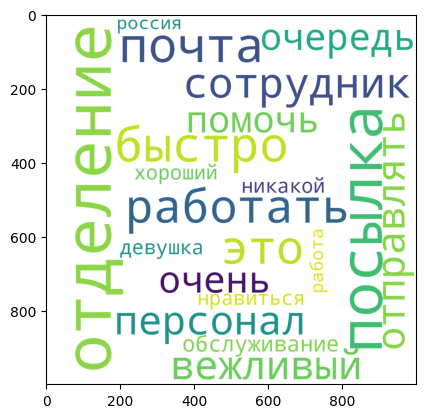

In [310]:
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(freq_pos)
plt.imshow(wc)

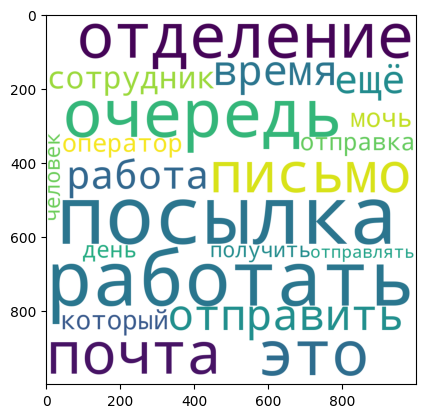

In [311]:
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(freq_neg)
plt.imshow(wc)

Уберем слова, которые встречаются в тексте всего один раз.

In [312]:
clean_freq_pos = []

for elem in freq_pos.items():
    if elem[1] != 1:
        clean_freq_pos.append(elem[0])

In [313]:
clean_freq_neg = []

for eelem in freq_neg.items():
    if eelem[1] != 1:
        clean_freq_neg.append(eelem[0])

Создадим множества

In [314]:
set_pos = set(clean_freq_pos)
set_neg = set(clean_freq_neg)

In [315]:
only_pos = set_pos - set_neg
only_neg = set_neg - set_pos

In [316]:
print('Кол-во слов во множестве негативных', len(only_neg))
print('Кол-во слов во множестве позитивных', len(only_pos))

Кол-во слов во множестве негативных 150
Кол-во слов во множестве позитивных 41


Множество негативных слов получилось довольно хаотичным, в него попало слишком много слов, среди которых есть и довольно нейтральные.

In [317]:
', '.join(set_pos & set_neg) #пересечение негативного и позитивного множеств

'выходной, стоять, просто, другой, место, это, сотрудник, почта, новый, персонал, раз, один, забирать, никакой, отправлять, обслуживание, работа, свой, человек, окно, посылка, день, пока, отправить, проблема, отправка, телефон, прийти, ранний, ещё, очень, очередь, время, девушка, россия, отделение, работать, город, такой'

## Функция для определения эмоциональной окраски отзыва

Так выглядит наш тестовый датасет:

In [318]:
test

,texts,stars,ton
175,Лучшее отделение почты,5,1
176,Самая адекватна почта в Абакане.,5,1
177,Дамы в данном почтовом отделении большие молод...,5,1
178,Присоединяюсь к отзывам. The best!!!,5,1
179,"Обожаемое отделение, переехали от туда, но все...",5,1
180,"Доброжелательный персонал , спасибо",5,1
181,Лучшее почтовое отделение в Абакане. Персонал ...,5,1
97,Отвратительный персонал,1,0
98,Не могу дозвониться уже второй день никто не о...,1,0
103,В 18:00 уже закрыты!!! График до 20:00,1,0


Функция для лемматизации и др.

In [319]:
def preprocessing(one_text):
    token_text = tokenization(one_text)
    lemma_text = []
    for w in token_text:
        if w not in stopwords.words('russian'):
            lemma_text.append(morph.parse(word)[0].normal_form)
    return lemma_text

In [320]:
def sentiment(review):
    cnt_pos = 0
    cnt_neg = 0
    for tt in review['texts']:
        for ww in preprocessing(tt):
            if ww in only_pos:
                cnt_pos += 1
            elif ww in only_neg:
                cnt_neg += 1
        if cnt_pos > cnt_neg:
            return '1'
        else:
            return '0'

*почему в алгоритме отсутствует условие cnt_neg == cnt_pos объясняется далее*

In [321]:
test['answer'] = test.apply(sentiment, axis=1)

In [322]:
test

,texts,stars,ton,answer
175,Лучшее отделение почты,5,1,1
176,Самая адекватна почта в Абакане.,5,1,0
177,Дамы в данном почтовом отделении большие молод...,5,1,1
178,Присоединяюсь к отзывам. The best!!!,5,1,1
179,"Обожаемое отделение, переехали от туда, но все...",5,1,0
180,"Доброжелательный персонал , спасибо",5,1,1
181,Лучшее почтовое отделение в Абакане. Персонал ...,5,1,1
97,Отвратительный персонал,1,0,0
98,Не могу дозвониться уже второй день никто не о...,1,0,1
103,В 18:00 уже закрыты!!! График до 20:00,1,0,0


Посчитаем качество при помощи accuracy:

In [323]:
from sklearn.metrics import accuracy_score
y_pred = test['answer']
y_true = test['ton']
accuracy_score(y_true, y_pred)

0.7142857142857143

Качество равно 0.7142857142857143

## Способы улучшения алгоритма

Проанализируем причины недостаточно хороших результатов.

In [324]:
test_extra = test

In [325]:
def sentiment_extra(review):
    cnt_pos = 0
    cnt_neg = 0
    for tt in review['texts']:
        for ww in preprocessing(tt):
            if ww in only_pos:
                cnt_pos += 1
            elif ww in only_neg:
                cnt_neg += 1
        if cnt_pos > cnt_neg:
            return cnt_pos, cnt_neg, 'positive'
        else:
            return cnt_pos, cnt_neg, 'negative'

test_extra['answer_extra'] = test_extra.apply(sentiment_extra, axis=1)
test_extra

,texts,stars,ton,answer,answer_extra
175,Лучшее отделение почты,5,1,1,"(1, 0, positive)"
176,Самая адекватна почта в Абакане.,5,1,0,"(0, 0, negative)"
177,Дамы в данном почтовом отделении большие молод...,5,1,1,"(1, 0, positive)"
178,Присоединяюсь к отзывам. The best!!!,5,1,1,"(1, 0, positive)"
179,"Обожаемое отделение, переехали от туда, но все...",5,1,0,"(0, 0, negative)"
180,"Доброжелательный персонал , спасибо",5,1,1,"(1, 0, positive)"
181,Лучшее почтовое отделение в Абакане. Персонал ...,5,1,1,"(1, 0, positive)"
97,Отвратительный персонал,1,0,0,"(0, 0, negative)"
98,Не могу дозвониться уже второй день никто не о...,1,0,1,"(1, 0, positive)"
103,В 18:00 уже закрыты!!! График до 20:00,1,0,0,"(0, 0, negative)"


При определении тональности в тестовых отзывах ни в одном из отзывов не были найдены слова из негативного множества.

In [326]:
', '.join(only_neg)

'полный, орать, уйти, электронный, советовать, плохо, нафиг, закрытый, два, отношение, класс, сказать, настроение, письмо, самый, нужно, шевелиться, стоить, бегать, карта, талончик, вечный, узнать, горячий, вечно, отстоять, сидеть, вс, принять, переадресация, открывать, заказной, забрать, должный, всётаки, самолёт, ждать, мочь, четвёртый, коробка, ой, данный, отказать, звонить, вообще, наорать, задержка, медленно, трубка, требовать, окошко, хотя, отстаивать, получатель, страховой, дверь, еле, кто, говорить, извещение, хамский, обращаться, первый, перепутать, повторно, истерично, касса, этот, услуга, вечерний, рука, закрыться, дать, график, понедельник, талон, документ, хамка, быть, отправитель, информация, скан, линия, несмотря, работник, отвратительный, никто, простоять, купить, заполнить, подходить, крайне, указать, итог, суббота, какой, бланк, либо, конверт, фамилия, заявление, образ, работница, получиться, отзыв, стоимость, оператор, минута, получить, сколько, писать, третий, слово

In [327]:
test_extra[7:14]['texts'].tolist()

['Отвратительный персонал',
 'Не могу дозвониться уже второй день никто не отвечает. Федеральный номер- робот- несёт всякую чушь',
 'В 18:00 уже закрыты!!! График до 20:00',
 'В 18:00 отделение уже закрывают , хотя график до 20:00 , в чем дело?',
 'Отвратительное обращение к посетителям, только и могут на повышенных тонах общаться и вечно заняты, хотя сидят 3 человека и работа только у одного из троих идёт',
 'Отвратительное отделение, работники ругаются матом при клиентах, ужас просто!',
 'Большие очереди, постоянно зависают компьютеры. Чтобы получить посылку надо потратить около часа.']

Если сравнить слова в тестовых отзывах и в используемом множестве, можно заметить, что в отзывах есть слова ярко-негативной окраски, не попавшие во множество (которое и так получилось довольно большим). Например, в отзывах присутствует слово "отвратительный", в то время как во множестве есть синонимичные слова "ужасный" (+ прилагательное с негативной окраской "хамский").

Исходя из отмеченных причин, можно предложить следующие способы решения:
- при бОльшем количестве данных можно сформировать более репрезентативные множества положительной и отрицательной лексики, можно будет выбрать наиболее частотные слова (с частотностью, например, более 10 вхождений на корпус негативных отзывов), встречающиеся в нескольких текстах, без существенного уменьшения множества.
- вместо поиска полных совпадений между леммами слов во множествах и в текстах отзывов можно смотреть на векторную близость слов и, таким образом, искать синонимы (например, *ужасный* и *отвратительный*)
- для более точных результатов можно присвоить словам во множествах определенные веса в зависимости от их частотности в текстах. Это поможет избежать неоднозначности в ответах, когда, например, в тексте найдено 1 положительное и 1 отрицательное слово, и, вероятно, улучшит точность работы алгоритма. Однако на наших данных проверить эту теорию невозможно, потому что в тестовых отзывах в принципе не находятся слова из отрицательного множества (именно поэтому в исходно алгоритме решающим было наличие положительных слов, случай с равным количеством положительных и негативных не учитывался).